In [3]:
# CÉLULA 1 (ATUALIZADA)

# --- FUNÇÕES ---
def add_all_features(df):
    # --- INDICADORES TÉCNICOS ---
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()
    
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    df['bollinger_upper'] = df['sma_20'] + (df['close'].rolling(window=20).std() * 2)
    df['bollinger_lower'] = df['sma_20'] - (df['close'].rolling(window=20).std() * 2)
    
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    
    # --- NOVA FEATURE: ATR (Average True Range) ---
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['atr_14'] = true_range.rolling(14).mean()
    
    # --- FEATURE DE RETORNO ---
    df['daily_return'] = df['close'].pct_change()
    
    # --- FEATURES DE TEMPO ---
    df['day_of_week'] = df.index.dayofweek.astype(float)
    df['day_of_month'] = df.index.day.astype(float)
    df['week_of_year'] = df.index.isocalendar().week.astype(float)
    df['month'] = df.index.month.astype(float)
    
    # Remover linhas com NaN resultantes dos cálculos de indicadores
    return df.dropna()

# O resto das funções (create_labels, create_sequences) permanece igual.
# ...

print("Função 'add_all_features' atualizada com ATR.")


Função 'add_all_features' atualizada com ATR.


--- INICIANDO EXPERIMENTO COM MODELO PROFUNDO (15m) ---
Alvo=1.0%, Stop=0.5%, Olhar à frente=48 velas
Preparação dos dados concluída com sucesso.
\nIniciando treino do modelo profundo...


/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - accuracy: 0.4771 - loss: 1.0202 - val_accuracy: 0.4410 - val_loss: 1.0596
Epoch 2/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 74s 38ms/step - accuracy: 0.5386 - loss: 0.9476 - val_accuracy: 0.3935 - val_loss: 1.1537
Epoch 3/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 70s 36ms/step - accuracy: 0.6163 - loss: 0.8353 - val_accuracy: 0.3969 - val_loss: 1.3644
Epoch 4/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - accuracy: 0.6767 - loss: 0.7301 - val_accuracy: 0.3702 - val_loss: 1.5664
Epoch 5/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.7295 - loss: 0.6304 - val_accuracy: 0.3839 - val_loss: 1.8625
Epoch 6/50
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - accuracy: 0.7630 - loss: 0.5667 - val_accuracy: 0.4056 - val_loss: 1.9656
Treino concluído com sucesso.
\nIniciando backtesting...
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step
Backtesting concluído com sucesso.
\n--- RESULTADOS FINAIS (15m com Modelo Profundo) ---


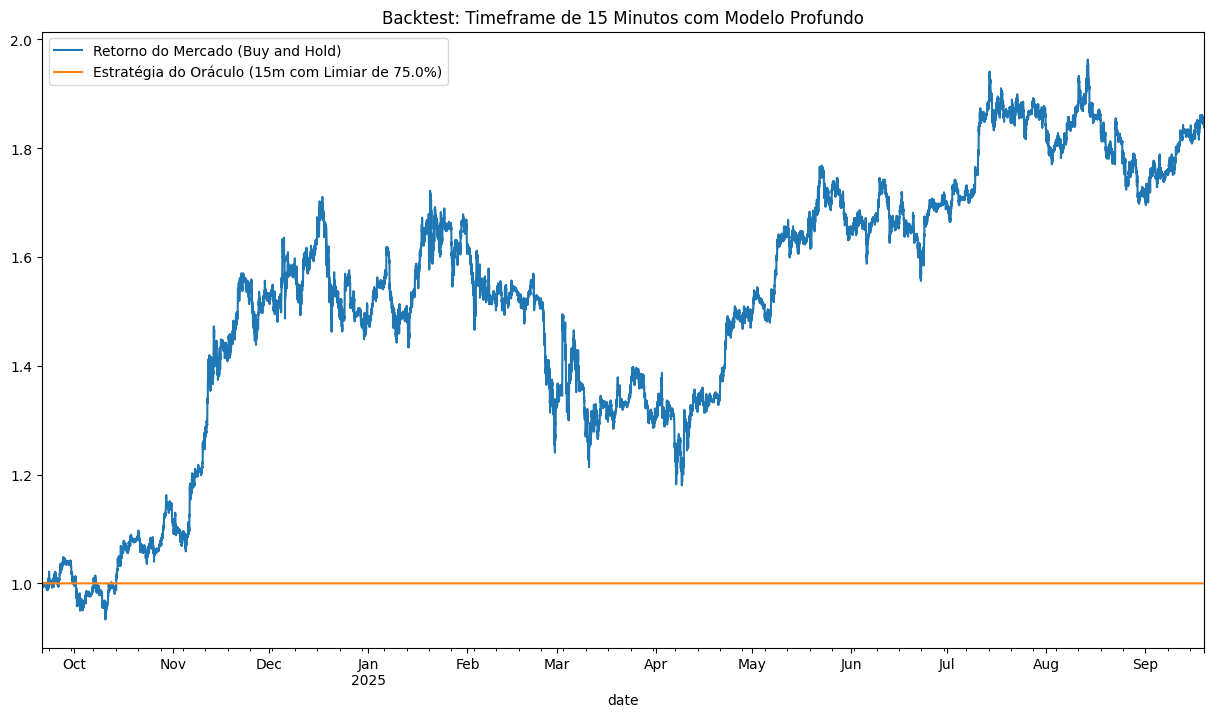

Retorno Total do Mercado: 83.84%
Retorno Total da Estratégia: 0.00%


In [5]:
# CÉLULA 2 (COMPLETA E ATUALIZADA): Executar o Pipeline para o Timeframe de 15m com Modelo Profundo

# --- PARÂMETROS ---
PROFIT_TARGET = 0.01   # Alvo de lucro de 1%
STOP_LOSS = 0.005      # Stop loss de 0.5%
LOOK_FORWARD = 48      # Olhar 12 horas para a frente (48 velas de 15m)
TIME_STEPS = 120       # Usar as últimas 30 horas de dados para prever (120 velas de 15m)
CONFIDENCE = 0.75      # Limiar de confiança

print(f"--- INICIANDO EXPERIMENTO COM MODELO PROFUNDO (15m) ---")
print(f"Alvo={PROFIT_TARGET*100}%, Stop={STOP_LOSS*100}%, Olhar à frente={LOOK_FORWARD} velas")

# 1. PREPARAÇÃO DOS DADOS
try:
    btc_df_raw = pd.read_feather('../user_data/data/binance/BTC_USDT-15m.feather')
    btc_df_raw['date'] = pd.to_datetime(btc_df_raw['date'])
    btc_df_raw.set_index('date', inplace=True)

    df_labeled = create_labels(btc_df_raw.copy(), LOOK_FORWARD, PROFIT_TARGET, STOP_LOSS)
    df_featured = add_all_features(df_labeled)

    y = df_featured['label']
    X = df_featured.drop(columns=['label', 'open', 'high', 'low', 'close', 'future_price', 'price_change'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

    y_train_adj = y_train_seq + 1
    
    print("Preparação dos dados concluída com sucesso.")

except Exception as e:
    print(f"ERRO na preparação dos dados: {e}")


# 2. TREINO DO MODELO
print("\\nIniciando treino do modelo profundo...")
try:
    # --- NOVA ARQUITETURA DE MODELO (MAIS PROFUNDA) ---
    model = Sequential([
        LSTM(units=128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(0.3),
        LSTM(units=64, return_sequences=True),
        Dropout(0.3),
        LSTM(units=32, return_sequences=False),
        Dropout(0.3),
        Dense(units=3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train_seq, y_train_adj, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)
    
    print("Treino concluído com sucesso.")

except Exception as e:
    print(f"ERRO no treino do modelo: {e}")


# 3. BACKTESTING
print("\\nIniciando backtesting...")
try:
    predictions_test = model.predict(X_test_seq)

    start_index = len(X_train) + TIME_STEPS
    test_prices = df_featured['close'].iloc[start_index:]
    backtest_df = pd.DataFrame({'close_price': test_prices, 'market_return': test_prices.pct_change()})

    backtest_df['signal'] = 0
    backtest_df.loc[predictions_test[:, 2] > CONFIDENCE, 'signal'] = 1
    backtest_df.loc[predictions_test[:, 0] > CONFIDENCE, 'signal'] = -1

    backtest_df['strategy_return'] = backtest_df['market_return'] * backtest_df['signal'].shift(1)
    backtest_df['cumulative_strategy'] = (1 + backtest_df['strategy_return']).cumprod()
    backtest_df['cumulative_market'] = (1 + backtest_df['market_return']).cumprod()
    
    print("Backtesting concluído com sucesso.")

except Exception as e:
    print(f"ERRO no backtesting: {e}")


# 4. RESULTADOS
print("\\n--- RESULTADOS FINAIS (15m com Modelo Profundo) ---")
try:
    total_strategy_return = (backtest_df['cumulative_strategy'].iloc[-1] - 1) * 100
    total_market_return = (backtest_df['cumulative_market'].iloc[-1] - 1) * 100

    plt.figure(figsize=(15, 8))
    backtest_df['cumulative_market'].plot(label='Retorno do Mercado (Buy and Hold)')
    backtest_df['cumulative_strategy'].plot(label=f'Estratégia do Oráculo (15m com Limiar de {CONFIDENCE*100}%)')
    plt.title('Backtest: Timeframe de 15 Minutos com Modelo Profundo')
    plt.legend()
    plt.show()

    print(f"Retorno Total do Mercado: {total_market_return:.2f}%")
    print(f"Retorno Total da Estratégia: {total_strategy_return:.2f}%")

except Exception as e:
    print(f"ERRO ao gerar resultados: {e}")
